In [78]:
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
mpl.rcParams['figure.figsize']=8,6
from datetime import datetime

In [13]:
def series_to_supervised(data, n_in=1, n_out=1, dropna=True):
    '''
    	data: origin data
    	n_in: 
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(),list()
    
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
        names+=[('var%d(t-%d)'%(j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i==0:
            names += [('var%d(t)'%(j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)'%(j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropna: # 是否去除缺失值的行
        agg.dropna(inplace=True)
    return agg

In [85]:
def plot_history(model_history):
    plt.plot(model_history.history['loss'],label='train_loss')
    plt.plot(model_history.history['val_loss'],label='vlaid_loss')
    plt.legend(fontsize=15)
    plt.title('loss-epoch graph',fontsize=15)
    plt.xlabel('epoch',fontsize=15)
    plt.ylabel('loss',fontsize=15)
    plt.grid(linestyle='--',alpha=0.5)
    plt.legend()
    plt.show()

In [9]:
data = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv')
data.drop(['year','month','day','hour','No'],axis=1,inplace=True)
data['pm2.5'].fillna(0, inplace=True)
data = data[24:].reset_index()
data.drop(['index'],axis=1,inplace=True)

In [11]:
data.columns=['pollution','dew','temp','press','wnd_dir','wnd_spd','snow','rain']

In [12]:
data.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [14]:
enc = OneHotEncoder(sparse=False)
obj_cols = ['wnd_dir']
trans = pd.DataFrame(enc.fit_transform(data[obj_cols]))
trans.columns=['dir_1','dir_2','dir_3','dir_4']
data.drop(obj_cols, axis=1, inplace=True)
oh_data = pd.concat([data, trans], axis=1)

In [17]:
oh_data.head()

,pollution,dew,temp,press,wnd_spd,snow,rain,dir_1,dir_2,dir_3,dir_4
0,129.0,-16,-4.0,1020.0,1.79,0,0,0.0,0.0,1.0,0.0
1,148.0,-15,-4.0,1020.0,2.68,0,0,0.0,0.0,1.0,0.0
2,159.0,-11,-5.0,1021.0,3.57,0,0,0.0,0.0,1.0,0.0
3,181.0,-7,-5.0,1022.0,5.36,1,0,0.0,0.0,1.0,0.0
4,138.0,-7,-5.0,1022.0,6.25,2,0,0.0,0.0,1.0,0.0


In [21]:
old_order = list(oh_data)
t=old_order[4]
old_order[4]=old_order[0]
old_order[0]=t
oh_data = oh_data[old_order]

In [22]:
oh_data.head()

,wnd_spd,dew,temp,press,pollution,snow,rain,dir_1,dir_2,dir_3,dir_4
0,1.79,-16,-4.0,1020.0,129.0,0,0,0.0,0.0,1.0,0.0
1,2.68,-15,-4.0,1020.0,148.0,0,0,0.0,0.0,1.0,0.0
2,3.57,-11,-5.0,1021.0,159.0,0,0,0.0,0.0,1.0,0.0
3,5.36,-7,-5.0,1022.0,181.0,1,0,0.0,0.0,1.0,0.0
4,6.25,-7,-5.0,1022.0,138.0,2,0,0.0,0.0,1.0,0.0


In [23]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(oh_data[[name for name in oh_data.columns]])

In [24]:
reframed_data = series_to_supervised(scaled_data, 1, 1)

In [26]:
useless_cols = reframed_data.columns[12:]
reframed_data.drop(useless_cols,axis=1,inplace=True)
reframed_data.head()
reframed_data.info()

train_ratio = 0.6
valid_ratio = 0.2

train_days = int(train_ratio*len(reframed_data))
valid_days = int(valid_ratio*len(reframed_data))
test_days = len(reframed_data)-train_days-valid_days

train = reframed_data.values[:train_days,:]
valid = reframed_data.values[train_days:train_days+valid_days,:]
test = reframed_data.values[train_days+valid_days:,:]

train_x, train_y = train[:,:-1], train[:,-1]
valid_x, valid_y = valid[:,:-1], valid[:,-1]
test_x, test_y = test[:,:-1], test[:,-1]

train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
valid_x = valid_x.reshape((valid_x.shape[0], 1, valid_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

print(train_x.shape,train_y.shape,valid_x.shape,valid_y.shape,test_x.shape,test_y.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43799 entries, 1 to 43799
Data columns (total 12 columns):
var1(t-1)     43799 non-null float64
var2(t-1)     43799 non-null float64
var3(t-1)     43799 non-null float64
var4(t-1)     43799 non-null float64
var5(t-1)     43799 non-null float64
var6(t-1)     43799 non-null float64
var7(t-1)     43799 non-null float64
var8(t-1)     43799 non-null float64
var9(t-1)     43799 non-null float64
var10(t-1)    43799 non-null float64
var11(t-1)    43799 non-null float64
var1(t)       43799 non-null float64
dtypes: float64(12)
memory usage: 4.3 MB
(26279, 1, 11) (26279,) (8759, 1, 11) (8759,) (8761, 1, 11) (8761,)


In [28]:
model = keras.Sequential([
    keras.layers.LSTM(50, activation='relu', input_shape=(train_x.shape[1],train_x.shape[2])),
    keras.layers.Dense(1, activation='linear')
])

model.compile(optimizer='adam',
             loss='mean_squared_error')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                12400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 12,451
Trainable params: 12,451
Non-trainable params: 0
_________________________________________________________________


In [29]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch%25==0:
            print(" ")
        print(".",end='')

model_history = model.fit(train_x, train_y,
                         epochs=50,
                         batch_size=72,
                         validation_data=(valid_x, valid_y),
                          verbose=0,
                        callbacks=[early_stop,PrintDot()],
                         shuffle=False)

 
.................

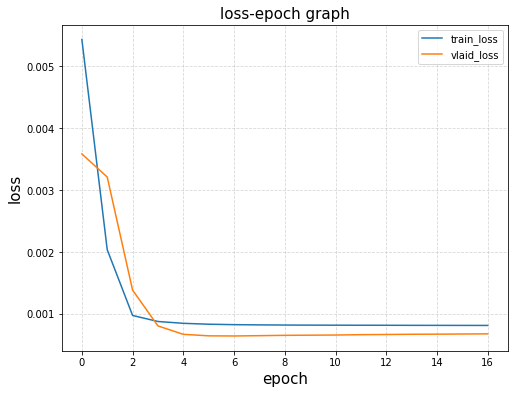

In [86]:
plot_history(model_history)

8761/8761 [==============================] - 1s 63us/step
0.0006002401498709045


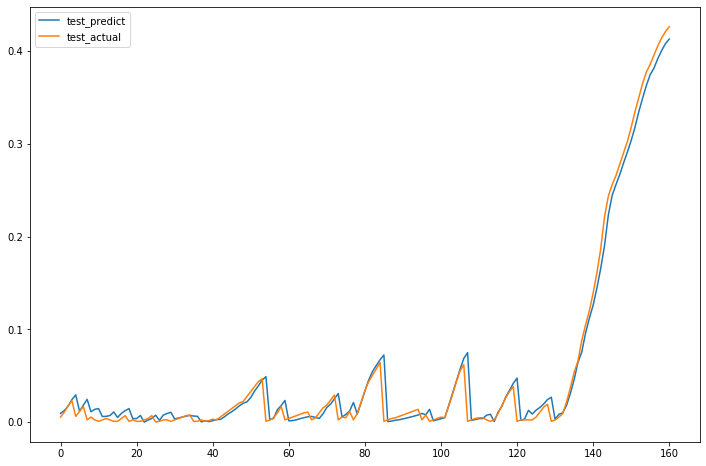

In [52]:
evaluate_res = model.evaluate(test_x,test_y)
print(evaluate_res)

preds = model.predict(test_x)
plt.plot(preds[8600:],label='test_predict')
plt.plot(test_y[8600:], label='test_actual')
plt.legend()
plt.show()

In [53]:

for i in range(10):
    preds=np.column_stack((preds, np.zeros(len(test_y))))
    
inverse_preds = scaler.inverse_transform(preds)
origin_test_y = oh_data['wnd_spd'][train_days+valid_days:]
origin_test_y = [x for x in origin_test_y]



In [74]:
def plot_trends(hour_begin, hour_end):
    plt.plot(inverse_preds[hour_begin:hour_end,0],label='actual_preds')
    plt.plot(origin_test_y[hour_begin:hour_end], label='actual_test_y')
    plt.legend(fontsize=15)
    plt.xlabel('hour',fontsize=15)
    plt.ylabel('wind_speed',fontsize=15)
    if hour_end-hour_begin<=24:
        plt.title('{0}_hours_line'.format(hour_end-hour_begin),fontsize=15)
    else:
        plt.title('{0:.0f}_days_line'.format((hour_end-hour_begin)/24),fontsize=15)
    plt.grid(linestyle='--',alpha=0.5)
    plt.show()

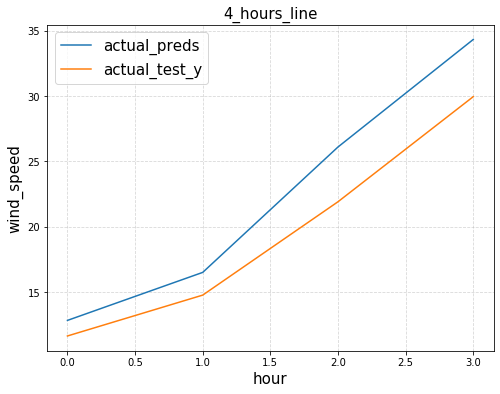

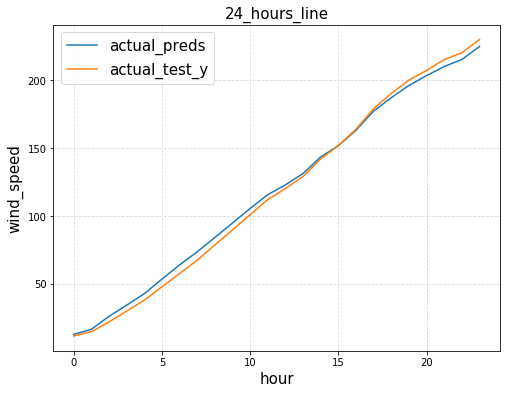

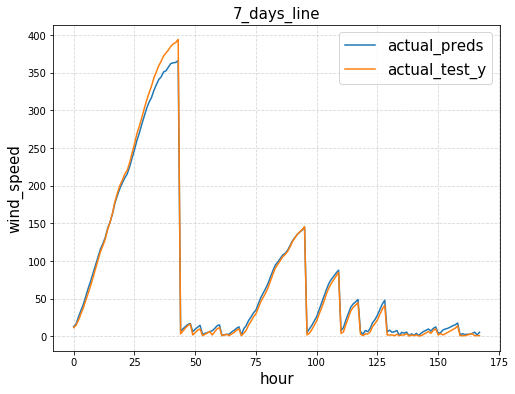

In [79]:
plot_trends(8000,8000+4)
plot_trends(8000,8000+24)
plot_trends(8000,8000+24*7)
